In [1]:
import sys, os
sys.path.insert(0, '..')
import time

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
from skimage import segmentation as segment, draw
from skimage.measure import regionprops
from skimage.future import graph

def _scale(image, scale=8):
    if scale == 1:
        return image
    else:
        image = np.repeat(image, scale, axis=0)
        image = np.repeat(image, scale, axis=1)
        return image
    
    
def _segment_with_mean(image, segmentation):
    mean_image = np.zeros_like(image)
    props = regionprops(segmentation + 1)
    
    for i, prop in enumerate(props):
        min_row, min_col, max_row, max_col = prop['bbox']
        sliced_image = image[min_row:max_row, min_col:max_col]
        color = sliced_image[prop['image']].mean(axis=0)
        
        for row, col in prop['coords']:
            mean_image[row, col] = color
        
    return mean_image


def draw_rag(image, segmentation):
    rag = graph.rag_mean_color(image, segmentation)    
    offset = 1
    map_array = np.arange(segmentation.max() + 1)
    for n, d in rag.nodes(data=True):
        for label in d['labels']:
            map_array[label] = offset
        offset += 1

    rag_labels = map_array[segmentation]
    regions = regionprops(rag_labels)
    for (n, data), region in zip(rag.nodes(data=True), regions):
        data['centroid'] = region['centroid']
    
    out = image.copy()
    
    for n1, n2, data in rag.edges(data=True):
        r1, c1 = map(int, rag.node[n1]['centroid'])
        r2, c2 = map(int, rag.node[n2]['centroid'])
        line = draw.line(r1, c1, r2, c2)
        out[line] = [1, 0, 0]
        
    for n, d in rag.nodes(data=True):
        r, c = map(int, rag.node[n]['centroid'])
        if r > 1 and c > 1 and r < image.shape[0] - 1 and c < image.shape[1] - 1:
            circle = draw.circle(r, c, 2)
            out[circle] = [0, 1, 0]
        
    return out


def showcase_image_segmentation(image, segmentation, duration, scale=8):  
    print('Execution time: {:.5f}s'.format(duration))
    print('Number of segments:', np.unique(segmentation).shape[0])
    
    image = _scale(image, scale)
    segmentation = _scale(segmentation, scale)
    
    fig = plt.figure()
    fig.add_subplot(221)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    fig.add_subplot(222)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(segment.mark_boundaries(image, segmentation, (1, 0, 0)))
    fig.add_subplot(223)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(_segment_with_mean(image, segmentation))
    fig.add_subplot(224)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(draw_rag(image, segmentation))
    
    plt.show()

## Load datasets

In [17]:
from skimage import color
import numpy as np

from lib.datasets import MNIST, Cifar10, PascalVOC

mnist = MNIST('../data/mnist').test.next_batch(1, shuffle=False)[0][0]
mnist = color.gray2rgb(np.reshape(mnist, (28, 28)))
cifar_10 = Cifar10('../data/cifar_10').test.next_batch(2, shuffle=False)[0][1]
pascal_voc = PascalVOC('../test_data').test.next_batch(3, shuffle=False)[0][2]

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
from lib.segmentation import slic, quickshift

## MNIST SLIC

Execution time: 0.01190s
Number of segments: 64


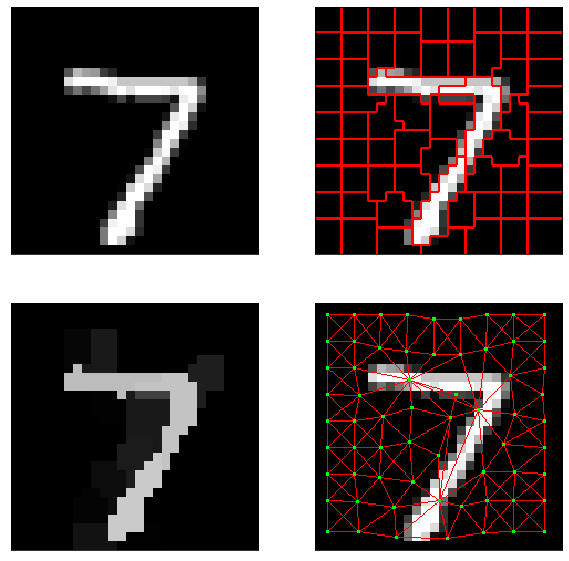

In [5]:
t_start = time.process_time()
segmentation = slic(mnist, num_segments=100, compactness=5, max_iterations=10, sigma=0)
duration = time.process_time() - t_start

plt.rcParams['figure.figsize'] = (10, 10)
showcase_image_segmentation(mnist, segmentation, duration)

## MNIST Quickshift

Execution time: 0.02792s
Number of segments: 78


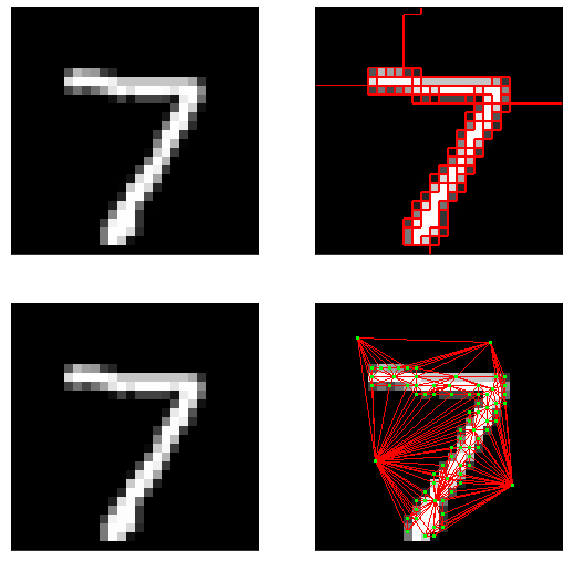

In [6]:
t_start = time.process_time()
segmentation = quickshift(mnist, ratio=1, kernel_size=2, max_dist=2, sigma=0)
duration = time.process_time() - t_start

plt.rcParams['figure.figsize'] = (10, 10)
showcase_image_segmentation(mnist, segmentation, duration)

## Cifar10 SLIC

Execution time: 0.01199s
Number of segments: 234


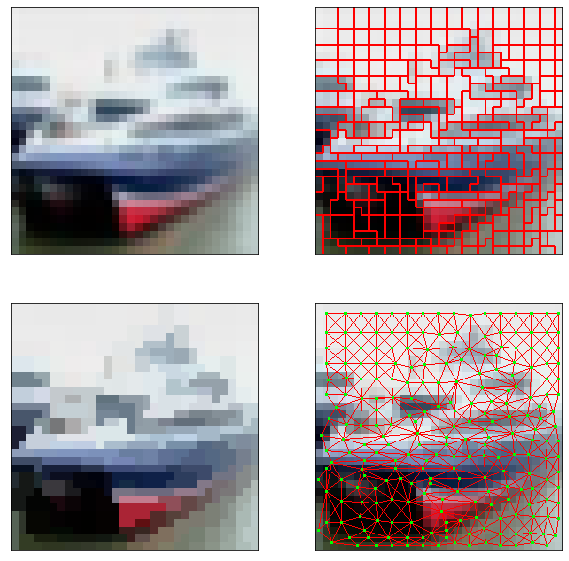

In [7]:
t_start = time.process_time()
segmentation = slic(cifar_10, num_segments=200, compactness=5, max_iterations=10, sigma=0)
duration = time.process_time() - t_start

plt.rcParams['figure.figsize'] = (10, 10)
showcase_image_segmentation(cifar_10, segmentation, duration)

## Cifar10 Quickshift

Execution time: 0.01308s
Number of segments: 174


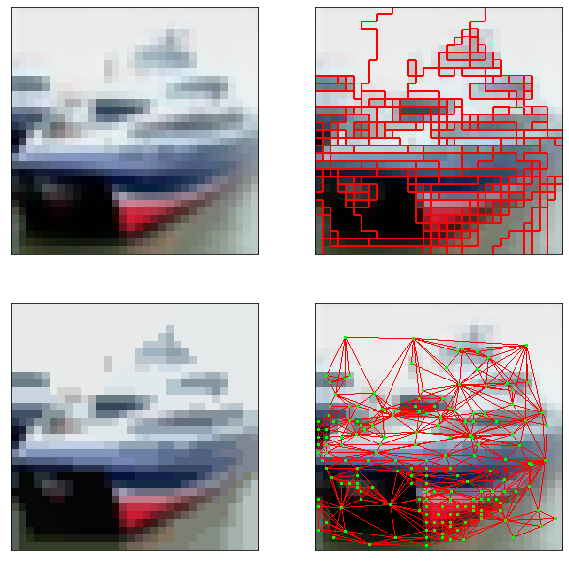

In [8]:
t_start = time.process_time()
segmentation = quickshift(cifar_10, ratio=1, kernel_size=1, max_dist=5, sigma=0)
duration = time.process_time() - t_start

plt.rcParams['figure.figsize'] = (10, 10)
showcase_image_segmentation(cifar_10, segmentation, duration)

## PascalVOC SLIC

Image shape: (366, 500, 3)
Execution time: 0.89550s
Number of segments: 1454


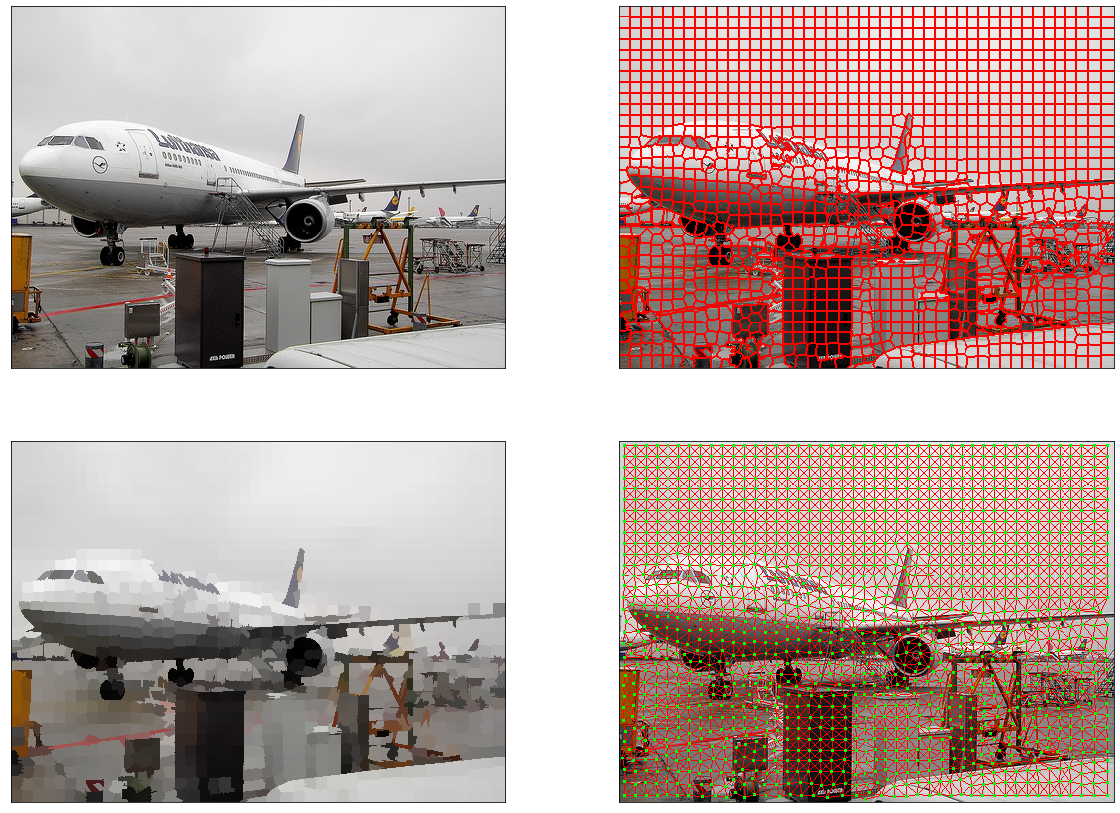

In [9]:
print('Image shape:', pascal_voc.shape)

t_start = time.process_time()
segmentation = slic(pascal_voc, num_segments=1600, compactness=30, max_iterations=10, sigma=0)
duration = time.process_time() - t_start

height, width, _ = pascal_voc.shape
plt.rcParams['figure.figsize'] = (20, 20 * height/width)
showcase_image_segmentation(pascal_voc, segmentation, duration, scale=1)

## PascalVOC Quickshift

Image shape: (366, 500, 3)
Execution time: 1.73106s
Number of segments: 1784


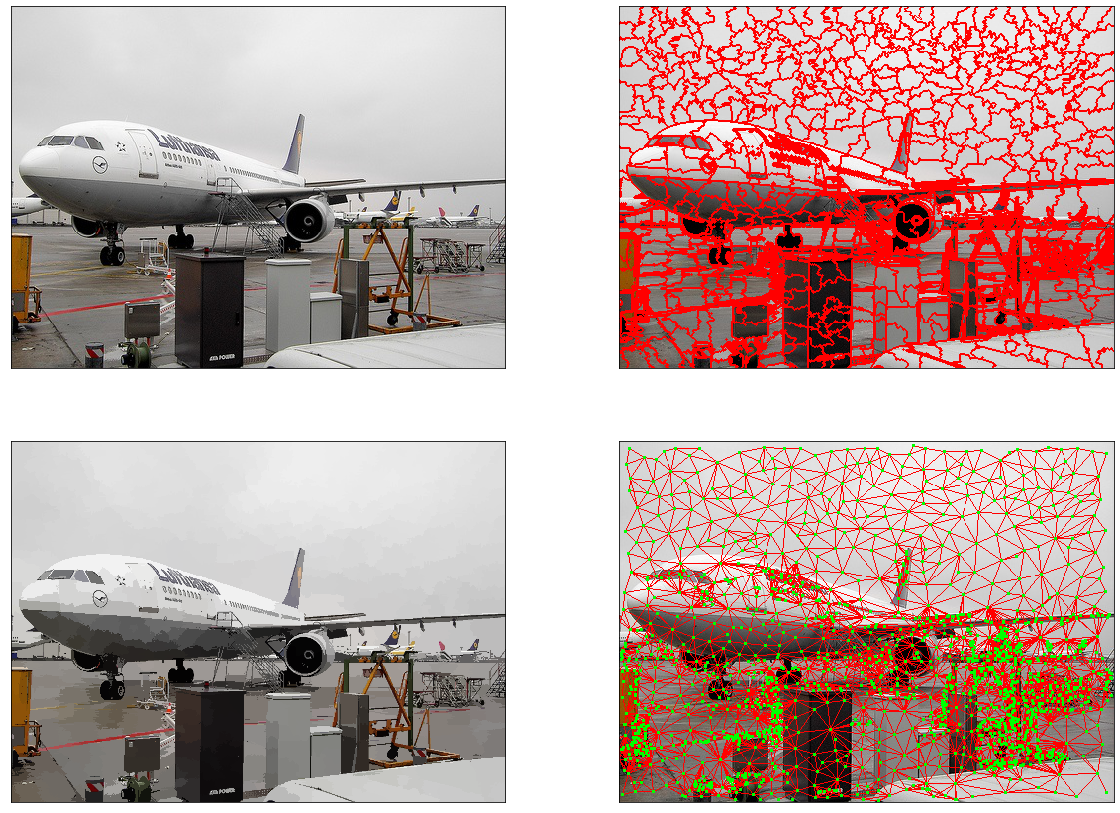

In [10]:
print('Image shape:', pascal_voc.shape)

t_start = time.process_time()
segmentation = quickshift(pascal_voc, ratio=0.75, kernel_size=2, max_dist=8, sigma=0)
duration = time.process_time() - t_start

height, width, _ = pascal_voc.shape
plt.rcParams['figure.figsize'] = (20, 20 * height/width)
showcase_image_segmentation(pascal_voc, segmentation, duration, scale=1)